# Boosting models with lambda rank

In [76]:
import pandas as pd
import numpy as np
import scipy
from tqdm import tqdm
import os

tqdm.pandas()


class Dataset():
    def __init__(self, path_train,path_val, path_test, dataset, history_len=100, basket_count_min=3,\
                                                         min_item_count = 5, basket_len = 30):
        self.basket_count_min = basket_count_min
        self.min_item_count = min_item_count
        self.history_len = history_len
        self.basket_len = basket_len
        
        self.train = pd.read_csv(path_train)
        self.val = pd.read_csv(path_val)
        self.test = pd.read_csv(path_test)
        
        self.model_name = 'boosting/' + 'data/' + dataset +'/'
        
        # используемые юзеры и айтемы
        basket_per_user = self.train[['user_id','basket_id']].drop_duplicates() \
            .groupby('user_id').agg({'basket_id':'count'}).reset_index()
        self.all_users = basket_per_user[basket_per_user['basket_id'] >= self.basket_count_min]['user_id'].tolist()
        print('Total users:', len(self.all_users))
        item_counts = self.train.groupby(['item_id']).size().to_frame(name = 'item_count').reset_index()
        self.all_items = item_counts[item_counts['item_count']>= self.min_item_count].item_id
        print('Total items:', len(self.all_items))
        
        ######################
        self.train_cleaned = self.train[ (self.train.user_id.isin(self.all_users)) & (self.train.item_id.isin(self.all_items))].\
                    sort_values(['user_id','date'],ascending=True)
        
        val_cleaned = self.val[ (self.val.user_id.isin(self.all_users)) & (self.val.item_id.isin(self.all_items))].\
                    sort_values(['user_id','date'],ascending=True)
        self.test_cleaned = self.test[ (self.test.user_id.isin(self.all_users)) & (self.test.item_id.isin(self.all_items))].\
                    sort_values(['user_id','date'],ascending=True)
        full_df = pd.concat([self.train_cleaned, val_cleaned, self.test_cleaned]).reset_index(drop=True)\
                                                    .sort_values(['user_id','date'],ascending=True)
        # необходимые аггрегаты
        user_baskets_train = self.train_cleaned[['user_id','date','basket_id']].drop_duplicates().\
                groupby(['user_id'])['basket_id'].apply(list).reset_index()
        self.user_baskets_train_dict = dict(zip(user_baskets_train['user_id'],user_baskets_train['basket_id']))
        
        user_baskets_val = val_cleaned[['user_id','basket_id']].drop_duplicates()
        self.user_baskets_val_dict = dict(zip(user_baskets_val['user_id'],user_baskets_val['basket_id']))
        
        user_baskets_test = self.test_cleaned[['user_id','basket_id']].drop_duplicates()
        self.user_baskets_test_dict = dict(zip(user_baskets_test['user_id'],user_baskets_test['basket_id']))
        
        
        basket_items = full_df.groupby(['basket_id'])['item_id'].apply(list).reset_index()
        self.basket_items_dict = dict(zip(basket_items['basket_id'],basket_items['item_id']))
        self.basket_items_dict['null'] = []
        
        basket_date = full_df[['basket_id','date']].drop_duplicates()
        self.basket_date_dict = dict(zip(basket_date['basket_id'],basket_date['date']))
        
        user_item_train = self.train_cleaned[['user_id','item_id']].drop_duplicates().\
                groupby(['user_id'])['item_id'].apply(list).reset_index()
        self.user_item_train_dict = dict(zip(user_item_train['user_id'],user_item_train['item_id']))
        
        ##########
        u_i_b = self.train_cleaned.groupby(['user_id', 'item_id'])['basket_id'].apply(list).reset_index()
        self.u_i_b_dict = dict(zip(zip(u_i_b.user_id, u_i_b.item_id), u_i_b.basket_id))
        
    def iterate_train_users(self, user):
        history, labels, user_id, item_id, basket_id, basket_date = [], [], [], [], [], []

        user_baskets = self.user_baskets_train_dict[user]
        user_items = self.user_item_train_dict[user]

        for item in user_items:

            baskets_with_item = self.u_i_b_dict[(user), (item)]

            first_date = self.basket_date_dict[baskets_with_item[0]]

            
            baskets_after_item = [b for b in user_baskets if self.basket_date_dict[b]>first_date]
     
            for i in range(max(0,len(baskets_after_item)-self.basket_len), len(baskets_after_item)):
                basket = baskets_after_item[i]
                prev_baskets =  baskets_after_item[:i]
                dates_list = [first_date]

                dates_list.extend([self.basket_date_dict[b] for b in prev_baskets if b in baskets_with_item]) 
                curr_basket_date = self.basket_date_dict[basket]
                hist = [curr_basket_date - elem for elem in dates_list]
                    
                if len(hist)<self.history_len:
                    hist = np.pad(hist, [(self.history_len-len(hist), 0)], mode='constant')
                else:
                    hist = hist[-self.history_len:]

                lab = int(basket in baskets_with_item)

                history.append(hist)
                labels.append(lab)
                user_id.append(user) 
                item_id.append(item)
                basket_id.append(basket) 
                basket_date.append(curr_basket_date)
        
        return history, labels, user_id, item_id, basket_id, basket_date
        
    def iterate_val_test_user(self, user, mode):
        if mode=='test':
            test_baskets = self.user_baskets_test_dict
        elif mode=='val':
            test_baskets = self.user_baskets_val_dict

        history, labels, user_id, item_id, basket_id, basket_date = [], [], [], [], [], []

        user_baskets = self.user_baskets_train_dict[user]
        user_items = self.user_item_train_dict[user]

        current_basket = test_baskets[user]

        curr_basket_date = self.basket_date_dict[current_basket]
        for item in user_items:

            baskets_with_item = self.u_i_b_dict[(user), (item)]

            dates_list = [self.basket_date_dict[b] for b in baskets_with_item]


            curr_basket_date = self.basket_date_dict[current_basket]
            hist = [curr_basket_date - elem for elem in dates_list]

            if len(hist)<self.history_len:
                hist = np.pad(hist, [(self.history_len-len(hist), 0)], mode='constant')
            else:
                hist = hist[-self.history_len:]

            lab = int(item in self.basket_items_dict[current_basket])

            history.append(hist)
            labels.append(lab)
            user_id.append(user) 
            item_id.append(item)
            basket_id.append(current_basket) 
            basket_date.append(curr_basket_date)

        return history, labels, user_id, item_id, basket_id, basket_date
       
    
    def create_train_data(self):
        save_path = self.model_name + str(self.basket_len) + '_train.npz'
        print(save_path)
        if os.path.isfile(save_path):
            print('Done!')
            res_array_sparse = scipy.sparse.load_npz(save_path)
            data = pd.DataFrame.sparse.from_spmatrix(res_array_sparse)
            data.columns = list(np.arange(self.history_len)) + ['labels', 'user_id', 'item_id', 'basket_id', 'basket_date']
            return data
        
        history, labels, user_id, item_id, basket_id, basket_date = [],[],[],[],[],[]
        for user in tqdm(self.all_users):
            history_u, labels_u, user_id_u, item_id_u, basket_id_u, basket_date_u = self.iterate_train_users(user)
            history.extend(history_u)
            labels.extend(labels_u)
            user_id.extend(user_id_u)
            item_id.extend(item_id_u)
            basket_id.extend(basket_id_u)
            basket_date.extend(basket_date_u)

        res_array = np.hstack([np.array(history), np.array(labels).reshape((-1, 1)),  np.array(user_id).reshape((-1, 1)),
            np.array(item_id).reshape((-1, 1)),  np.array(basket_id).reshape((-1, 1)),  np.array(basket_date).reshape((-1, 1))])
        
        res_array_sparse = scipy.sparse.csr_matrix(res_array)#.astype('int32'))
        scipy.sparse.save_npz(save_path,res_array_sparse)
        
        data = pd.DataFrame.sparse.from_spmatrix(res_array_sparse)
        data.columns = list(np.arange(self.history_len)) + ['labels', 'user_id', 'item_id', 'basket_id', 'basket_date']
        
        return data

        
    def create_val_test_data(self, mode):
        save_path = self.model_name + str(self.basket_len) + f'_{mode}.npz'
        print(save_path)  
      
        if os.path.isfile(save_path):
            print('Done!')
            res_array_sparse = scipy.sparse.load_npz(save_path)
            data = pd.DataFrame.sparse.from_spmatrix(res_array_sparse)
            data.columns = list(np.arange(self.history_len)) + ['labels', 'user_id', 'item_id', 'basket_id', 'basket_date']
            return data
        
        history, labels, user_id, item_id, basket_id, basket_date = [],[],[],[],[],[]
        
        if mode=='test':
            test_users = list(self.user_baskets_test_dict.keys())
        elif mode=='val':
            test_users = list(self.user_baskets_val_dict.keys())
        
        for user in tqdm(test_users):
            history_u, labels_u, user_id_u, item_id_u, basket_id_u, basket_date_u = self.iterate_val_test_user(user, mode=mode)
            history.extend(history_u)
            labels.extend(labels_u)
            user_id.extend(user_id_u)
            item_id.extend(item_id_u)
            basket_id.extend(basket_id_u)
            basket_date.extend(basket_date_u)

        res_array = np.hstack([np.array(history), np.array(labels).reshape((-1, 1)),  np.array(user_id).reshape((-1, 1)),
            np.array(item_id).reshape((-1, 1)),  np.array(basket_id).reshape((-1, 1)),  np.array(basket_date).reshape((-1, 1))])
        
        res_array_sparse = scipy.sparse.csr_matrix(res_array)#.astype('int32'))
        scipy.sparse.save_npz(save_path,res_array_sparse)
        
        data = pd.DataFrame.sparse.from_spmatrix(res_array_sparse)
        data.columns = list(np.arange(self.history_len)) + ['labels', 'user_id', 'item_id', 'basket_id', 'basket_date']
        return data

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.2)

from IPython.display import clear_output
%matplotlib inline

import pandas as pd
import plotly.express as px
import numpy as np
from tqdm import tqdm

tqdm.pandas()

from sklearn.metrics import accuracy_score, roc_auc_score

from tqdm.notebook import tqdm

import os
import scipy

from lightgbm import LGBMRanker

In [6]:
from metrics import recall_k, ndcg_k, precision_k, hitrate_k, repeat_score_item, repeat_score_user
from boosting.create_dataset import Dataset

In [7]:
# predict function
def predict(df, th=0):
    
    df['user_id'] = df['user_id'].astype('int64')
    df['item_id'] = df['item_id'].astype('int64')
    
    test_users = pd.DataFrame(dataset.test_cleaned.user_id.unique(), columns=['user_id'])
    df = df[df.preds_scores>=th]       
    df = df.sort_values(by='preds_scores', ascending=False)
    
    res = df.groupby('user_id').agg({'item_id': list}).reset_index()
    res = test_users.merge(res, how='left')
    res['item_id'] = res['item_id'].fillna("").apply(list)
    return res

In [8]:
def calculate_metrics(path_test, result):    
    test_baskets = pd.read_csv(path_test)
    user_test_baskets_df = test_baskets.groupby('user_id')['item_id'].apply(list).reset_index()
    user_test_baskets_dict = dict(zip( user_test_baskets_df['user_id'],user_test_baskets_df['item_id']))
    print('predictions ready', result.user_id.nunique())
    print('number of final test users:',result.user_id.nunique())
    for k in [5,10,20,'B']:
        print(k)
        recall_scores = {}
        ndcg_scores = {}
        precision_scores = {}
        hitrate_scores = {}
        #zero = 0
        for user in result.user_id.unique():

            top_items = result[result.user_id==user].item_id.values[0]

            if k == 'B':
                recall_scores[user] = recall_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
                ndcg_scores[user] = ndcg_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
                precision_scores[user] = precision_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
                hitrate_scores[user] = hitrate_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
            else:
                recall_scores[user] = recall_k(user_test_baskets_dict[user],top_items,k)
                ndcg_scores[user] = ndcg_k(user_test_baskets_dict[user],top_items,k)
                precision_scores[user] = precision_k(user_test_baskets_dict[user],top_items,k)
                hitrate_scores[user] = hitrate_k(user_test_baskets_dict[user],top_items,k)
        #print(zero)
        print('recall:',np.mean(list(recall_scores.values())))
        print('ndcg:',np.mean(list(ndcg_scores.values())))
        print('precision:',np.mean(list(precision_scores.values())))
        print('hitrate:',np.mean(list(hitrate_scores.values())))

In [9]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    feature_names = np.array([f'{np.abs(50-col)}_prev_basket'  \
     if isinstance(col, (int, np.int,np.int32, np.int64)) else col for col in feature_names])

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    fi_df = fi_df.head(10)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' feature importance')
    plt.xlabel('feature importance')
    plt.ylabel('feature names')

# Dunnhumby

In [5]:
dataset_name = 'dunnhumby_cj'

In [6]:
path_train = f'data/{dataset_name}/baskets/train_baskets.csv'
path_test = f'data/{dataset_name}/baskets/test_baskets.csv'
path_val = f'data/{dataset_name}/baskets/valid_baskets.csv'

In [7]:
dataset = Dataset(path_train,path_val, path_test, dataset=dataset_name, history_len=50, basket_len=50)

Total users: 2483
Total items: 36963


In [8]:
train = dataset.create_train_data()

val = dataset.create_val_test_data(mode='val')

test = dataset.create_val_test_data(mode='test')

boosting/data/dunnhumby_cj/50_train.npz
Done!
boosting/data/dunnhumby_cj/50_val.npz
Done!
boosting/data/dunnhumby_cj/50_test.npz
Done!


In [9]:
train.shape, val.shape, test.shape

((13974032, 55), (177804, 55), (185085, 55))

#### LGBM Ranker

In [10]:
train = train.sort_values(by = 'basket_id')
val = val.sort_values(by = 'basket_id')
test = test.sort_values(by = 'basket_id')

In [11]:
# функция для группировки при ранжировании
get_group_size = lambda df: df.reset_index().groupby("basket_id")['basket_id'].count()

In [12]:
# item_id - категориальная фича
train['item_id'] = train['item_id'].sparse.to_dense().astype('category')
val['item_id'] = val['item_id'].sparse.to_dense().astype('category')
test['item_id'] = test['item_id'].sparse.to_dense().astype('category')
# basket_id в int для правильной группировки
train['basket_id'] = train['basket_id'].sparse.to_dense().astype('int')
val['basket_id'] = val['basket_id'].sparse.to_dense().astype('int')
test['basket_id'] = test['basket_id'].sparse.to_dense().astype('int')

In [13]:
train_groups = get_group_size(train)
val_groups = get_group_size(val)

In [14]:
X_tr, y_tr = train.drop(['user_id','labels', 'basket_id'], axis=1), train.labels, 
X_val, y_val = val.drop(['user_id','labels', 'basket_id'], axis=1), val.labels
X_test, y_test = test.drop(['user_id','labels', 'basket_id'], axis=1), test.labels

In [15]:
ranker = LGBMRanker(n_estimators=300)

In [16]:
ranker.fit(X_tr, y_tr, group=train_groups, 
           eval_set = [(X_val, y_val)], eval_group=[val_groups], 
           early_stopping_rounds=100, eval_at=(5, 10, 20))

C:\Users\dkidi\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\dkidi\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\dkidi\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's ndcg@5: 0.520842	valid_0's ndcg@10: 0.543292	valid_0's ndcg@20: 0.57314
[2]	valid_0's ndcg@5: 0.542483	valid_0's ndcg@10: 0.56224	valid_0's ndcg@20: 0.592113
[3]	valid_0's ndcg@5: 0.548777	valid_0's ndcg@10: 0.56697	valid_0's ndcg@20: 0.595804
[4]	valid_0's ndcg@5: 0.552046	valid_0's ndcg@10: 0.566978	valid_0's ndcg@20: 0.595704
[5]	valid_0's ndcg@5: 0.550229	valid_0's ndcg@10: 0.568039	valid_0's ndcg@20: 0.596687
[6]	valid_0's ndcg@5: 0.550768	valid_0's ndcg@10: 0.569177	valid_0's ndcg@20: 0.596582
[7]	valid_0's ndcg@5: 0.554529	valid_0's ndcg@10: 0.573024	valid_0's ndcg@20: 0.598836
[8]	valid_0's ndcg@5: 0.554436	valid_0's ndcg@10: 0.572877	valid_0's ndcg@20: 0.599419
[9]	valid_0's ndcg@5: 0.554159	valid_0's ndcg@10: 0.574197	valid_0's ndcg@20: 0.600147
[10]	valid_0's ndcg@5: 0.552651	valid_0's ndcg@10: 0.574371	valid_0's ndcg@20: 0.599689
[11]	valid_0's ndcg@5: 0.554433	valid_0's ndcg@10: 0.57512	valid_0's ndcg@20: 0.601767
[12]	valid_0's ndcg@5: 0.55409	valid_0's ndcg

[95]	valid_0's ndcg@5: 0.55916	valid_0's ndcg@10: 0.577833	valid_0's ndcg@20: 0.605561
[96]	valid_0's ndcg@5: 0.559722	valid_0's ndcg@10: 0.578014	valid_0's ndcg@20: 0.606096
[97]	valid_0's ndcg@5: 0.559846	valid_0's ndcg@10: 0.57788	valid_0's ndcg@20: 0.606246
[98]	valid_0's ndcg@5: 0.560764	valid_0's ndcg@10: 0.578564	valid_0's ndcg@20: 0.607099
[99]	valid_0's ndcg@5: 0.560764	valid_0's ndcg@10: 0.57856	valid_0's ndcg@20: 0.607059
[100]	valid_0's ndcg@5: 0.560764	valid_0's ndcg@10: 0.578503	valid_0's ndcg@20: 0.607036
[101]	valid_0's ndcg@5: 0.560856	valid_0's ndcg@10: 0.578044	valid_0's ndcg@20: 0.607096
[102]	valid_0's ndcg@5: 0.560798	valid_0's ndcg@10: 0.577892	valid_0's ndcg@20: 0.607038
[103]	valid_0's ndcg@5: 0.560386	valid_0's ndcg@10: 0.578343	valid_0's ndcg@20: 0.60698
[104]	valid_0's ndcg@5: 0.559971	valid_0's ndcg@10: 0.577831	valid_0's ndcg@20: 0.606554
[105]	valid_0's ndcg@5: 0.560726	valid_0's ndcg@10: 0.578175	valid_0's ndcg@20: 0.606931
[106]	valid_0's ndcg@5: 0.5605

LGBMRanker(n_estimators=300)

Важность признаков

In [18]:
dict(sorted(dict(zip(X_tr.columns, ranker.feature_importances_)).items(), key=lambda x:x[1],  reverse=True))

{'item_id': 1246,
 49: 170,
 47: 71,
 48: 67,
 46: 47,
 45: 25,
 43: 18,
 44: 18,
 39: 11,
 42: 10,
 30: 9,
 40: 8,
 41: 8,
 35: 7,
 21: 6,
 36: 5,
 6: 4,
 32: 4,
 33: 4,
 'basket_date': 4,
 12: 3,
 20: 3,
 28: 3,
 34: 3,
 38: 3,
 5: 2,
 25: 2,
 31: 2,
 37: 2,
 4: 1,
 9: 1,
 15: 1,
 23: 1,
 29: 1,
 0: 0,
 1: 0,
 2: 0,
 3: 0,
 7: 0,
 8: 0,
 10: 0,
 11: 0,
 13: 0,
 14: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 22: 0,
 24: 0,
 26: 0,
 27: 0}

C:\Users\dkidi\AppData\Local\Temp\ipykernel_20944\3699646160.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(col, (int, np.int,np.int32, np.int64)) else col for col in feature_names])


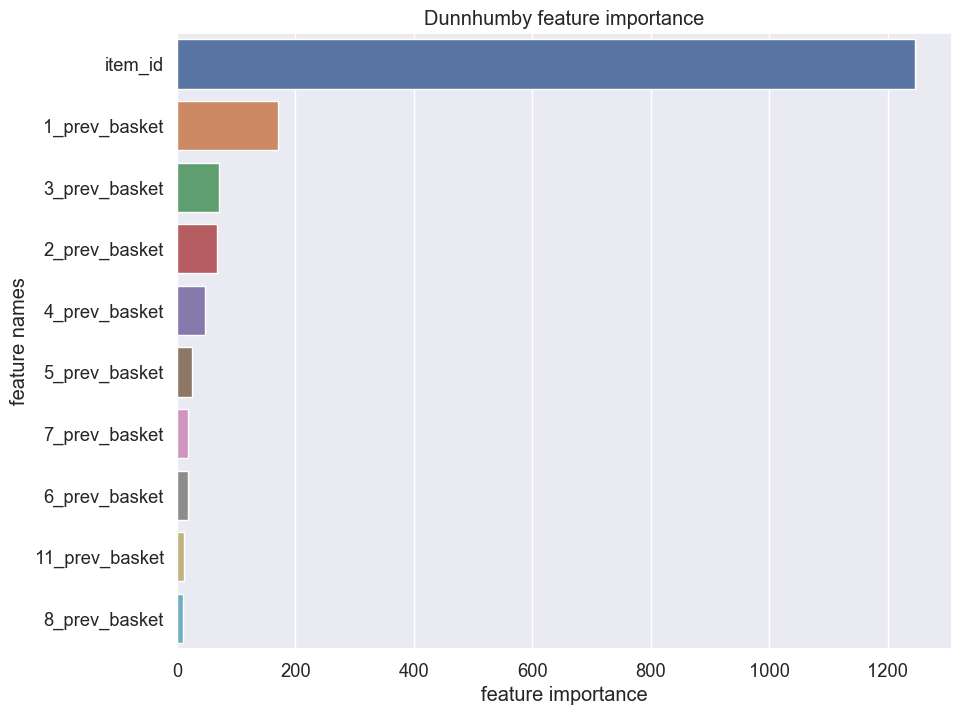

In [47]:
plot_feature_importance(ranker.feature_importances_,X_tr.columns, 'Dunnhumby')

In [20]:
preds = ranker.predict(X_test)
res = test[['user_id', 'item_id']].copy()
res['preds_scores'] = preds
result = predict(res, th = preds.min()-1)
print("ROC AUC =",roc_auc_score(y_test, preds))

ROC AUC = 0.7802097038773024


C:\Users\dkidi\AppData\Local\Temp\ipykernel_20944\870205799.py:4: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  df['user_id'] = df['user_id'].astype('int64')
C:\Users\dkidi\AppData\Local\Temp\ipykernel_20944\870205799.py:11: FutureWarning: In a future version, passing a SparseArray to pd.Index will store that array directly instead of converting to a dense numpy ndarray. To retain the old behavior, use pd.Index(arr.to_numpy()) instead
  res = df.groupby('user_id').agg({'item_id': list}).reset_index()


In [21]:
calculate_metrics(path_test, result)

predictions ready 1224
number of final test users: 1224
5
recall: 0.12755500097587327
ndcg: 0.1908295409505633
precision: 0.1715686274509804
hitrate: 0.4861111111111111
10
recall: 0.16611214961907297
ndcg: 0.1557118468659651
precision: 0.1309640522875817
hitrate: 0.565359477124183
20
recall: 0.21068938785789865
ndcg: 0.12139431076231869
precision: 0.09452614379084967
hitrate: 0.6290849673202614
B
recall: 0.145893364101325
ndcg: 0.16689151598718918
precision: 0.145893364101325
hitrate: 0.5122549019607843


# Instacart

In [10]:
dataset_name = 'instacart'

In [11]:
path_train = f'data/{dataset_name}/baskets/train_baskets_sample30k.csv'
path_test = f'data/{dataset_name}/baskets/test_baskets_sample30k.csv'
path_val = f'data/{dataset_name}/baskets/valid_baskets_sample30k.csv'

In [12]:
dataset = Dataset(path_train,path_val, path_test, dataset=dataset_name, history_len=50, basket_len=50)

Total users: 26828
Total items: 29396


In [13]:
train = dataset.create_train_data()

val = dataset.create_val_test_data(mode='val')

test = dataset.create_val_test_data(mode='test')

boosting/data/instacart/50_train.npz
Done!
boosting/data/instacart/50_val.npz
Done!
boosting/data/instacart/50_test.npz
Done!


In [14]:
train.shape, val.shape, test.shape

((10528763, 55), (354470, 55), (348067, 55))

## LGBM Ranker

In [15]:
train = train.sort_values(by = 'basket_id')
val = val.sort_values(by = 'basket_id')
test = test.sort_values(by = 'basket_id')

In [16]:
# функция для группировки при ранжировании
get_group_size = lambda df: df.reset_index().groupby("basket_id")['basket_id'].count()

In [17]:
# item_id - категориальная фича
train['item_id'] = train['item_id'].sparse.to_dense().astype('category')
val['item_id'] = val['item_id'].sparse.to_dense().astype('category')
test['item_id'] = test['item_id'].sparse.to_dense().astype('category')
# basket_id в int для правильной группировки
train['basket_id'] = train['basket_id'].sparse.to_dense().astype('int')
val['basket_id'] = val['basket_id'].sparse.to_dense().astype('int')
test['basket_id'] = test['basket_id'].sparse.to_dense().astype('int')

In [18]:
train_groups = get_group_size(train)
val_groups = get_group_size(val)

In [19]:
X_tr, y_tr = train.drop(['user_id','labels', 'basket_id'], axis=1), train.labels, 
X_val, y_val = val.drop(['user_id','labels', 'basket_id'], axis=1), val.labels
X_test, y_test = test.drop(['user_id','labels', 'basket_id'], axis=1), test.labels

In [ ]:
#reg_alpha, reg_lambda, num_leaves

In [70]:
ranker = LGBMRanker(n_estimators=300, reg_alpha=0.2, reg_lambda=0.2)

In [71]:
ranker.fit(X_tr, y_tr, group=train_groups, 
           eval_set = [(X_val, y_val)], eval_group=[val_groups], 
           early_stopping_rounds=100, eval_at=(5, 10, 20))

[1]	valid_0's ndcg@5: 0.665712	valid_0's ndcg@10: 0.705805	valid_0's ndcg@20: 0.749191
[2]	valid_0's ndcg@5: 0.674779	valid_0's ndcg@10: 0.712402	valid_0's ndcg@20: 0.755385
[3]	valid_0's ndcg@5: 0.676367	valid_0's ndcg@10: 0.713666	valid_0's ndcg@20: 0.756558
[4]	valid_0's ndcg@5: 0.676117	valid_0's ndcg@10: 0.713428	valid_0's ndcg@20: 0.756389
[5]	valid_0's ndcg@5: 0.677423	valid_0's ndcg@10: 0.714688	valid_0's ndcg@20: 0.757082
[6]	valid_0's ndcg@5: 0.677776	valid_0's ndcg@10: 0.714866	valid_0's ndcg@20: 0.757496
[7]	valid_0's ndcg@5: 0.678195	valid_0's ndcg@10: 0.715112	valid_0's ndcg@20: 0.757602
[8]	valid_0's ndcg@5: 0.678542	valid_0's ndcg@10: 0.715185	valid_0's ndcg@20: 0.757873
[9]	valid_0's ndcg@5: 0.678484	valid_0's ndcg@10: 0.715311	valid_0's ndcg@20: 0.75803
[10]	valid_0's ndcg@5: 0.679044	valid_0's ndcg@10: 0.715786	valid_0's ndcg@20: 0.758299
[11]	valid_0's ndcg@5: 0.679295	valid_0's ndcg@10: 0.716059	valid_0's ndcg@20: 0.758442
[12]	valid_0's ndcg@5: 0.679612	valid_0's 

[95]	valid_0's ndcg@5: 0.684568	valid_0's ndcg@10: 0.721001	valid_0's ndcg@20: 0.763
[96]	valid_0's ndcg@5: 0.684594	valid_0's ndcg@10: 0.720962	valid_0's ndcg@20: 0.762981
[97]	valid_0's ndcg@5: 0.684642	valid_0's ndcg@10: 0.720945	valid_0's ndcg@20: 0.762976
[98]	valid_0's ndcg@5: 0.684687	valid_0's ndcg@10: 0.720968	valid_0's ndcg@20: 0.763049
[99]	valid_0's ndcg@5: 0.684701	valid_0's ndcg@10: 0.721007	valid_0's ndcg@20: 0.763062
[100]	valid_0's ndcg@5: 0.684698	valid_0's ndcg@10: 0.721033	valid_0's ndcg@20: 0.763035
[101]	valid_0's ndcg@5: 0.684725	valid_0's ndcg@10: 0.721066	valid_0's ndcg@20: 0.763062
[102]	valid_0's ndcg@5: 0.684774	valid_0's ndcg@10: 0.721134	valid_0's ndcg@20: 0.763082
[103]	valid_0's ndcg@5: 0.684806	valid_0's ndcg@10: 0.721099	valid_0's ndcg@20: 0.763074
[104]	valid_0's ndcg@5: 0.684776	valid_0's ndcg@10: 0.721129	valid_0's ndcg@20: 0.763025
[105]	valid_0's ndcg@5: 0.684765	valid_0's ndcg@10: 0.72116	valid_0's ndcg@20: 0.763099
[106]	valid_0's ndcg@5: 0.6848

[188]	valid_0's ndcg@5: 0.684889	valid_0's ndcg@10: 0.721483	valid_0's ndcg@20: 0.763379
[189]	valid_0's ndcg@5: 0.684806	valid_0's ndcg@10: 0.721453	valid_0's ndcg@20: 0.763341
[190]	valid_0's ndcg@5: 0.684805	valid_0's ndcg@10: 0.721462	valid_0's ndcg@20: 0.76335
[191]	valid_0's ndcg@5: 0.684814	valid_0's ndcg@10: 0.721481	valid_0's ndcg@20: 0.763345
[192]	valid_0's ndcg@5: 0.684786	valid_0's ndcg@10: 0.721521	valid_0's ndcg@20: 0.763358
[193]	valid_0's ndcg@5: 0.684795	valid_0's ndcg@10: 0.721529	valid_0's ndcg@20: 0.763376
[194]	valid_0's ndcg@5: 0.684731	valid_0's ndcg@10: 0.72149	valid_0's ndcg@20: 0.763354
[195]	valid_0's ndcg@5: 0.684748	valid_0's ndcg@10: 0.721468	valid_0's ndcg@20: 0.763333
[196]	valid_0's ndcg@5: 0.684725	valid_0's ndcg@10: 0.721493	valid_0's ndcg@20: 0.763345
[197]	valid_0's ndcg@5: 0.684713	valid_0's ndcg@10: 0.721499	valid_0's ndcg@20: 0.763341
[198]	valid_0's ndcg@5: 0.684682	valid_0's ndcg@10: 0.721491	valid_0's ndcg@20: 0.763315
[199]	valid_0's ndcg@5:

LGBMRanker(n_estimators=300, reg_alpha=0.2, reg_lambda=0.2)

Важность признаков

In [72]:
dict(sorted(dict(zip(X_tr.columns, ranker.feature_importances_)).items(), key=lambda x:x[1],  reverse=True))

{'item_id': 3736,
 49: 242,
 47: 162,
 48: 116,
 46: 107,
 45: 62,
 44: 44,
 43: 40,
 41: 29,
 42: 28,
 40: 22,
 33: 20,
 39: 19,
 37: 17,
 38: 15,
 35: 14,
 36: 11,
 28: 10,
 34: 9,
 25: 8,
 32: 6,
 15: 5,
 21: 5,
 22: 5,
 26: 5,
 27: 4,
 0: 3,
 19: 3,
 20: 3,
 24: 3,
 29: 3,
 30: 3,
 31: 3,
 14: 2,
 18: 2,
 2: 1,
 10: 1,
 16: 1,
 23: 1,
 1: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 11: 0,
 12: 0,
 13: 0,
 17: 0,
 'basket_date': 0}

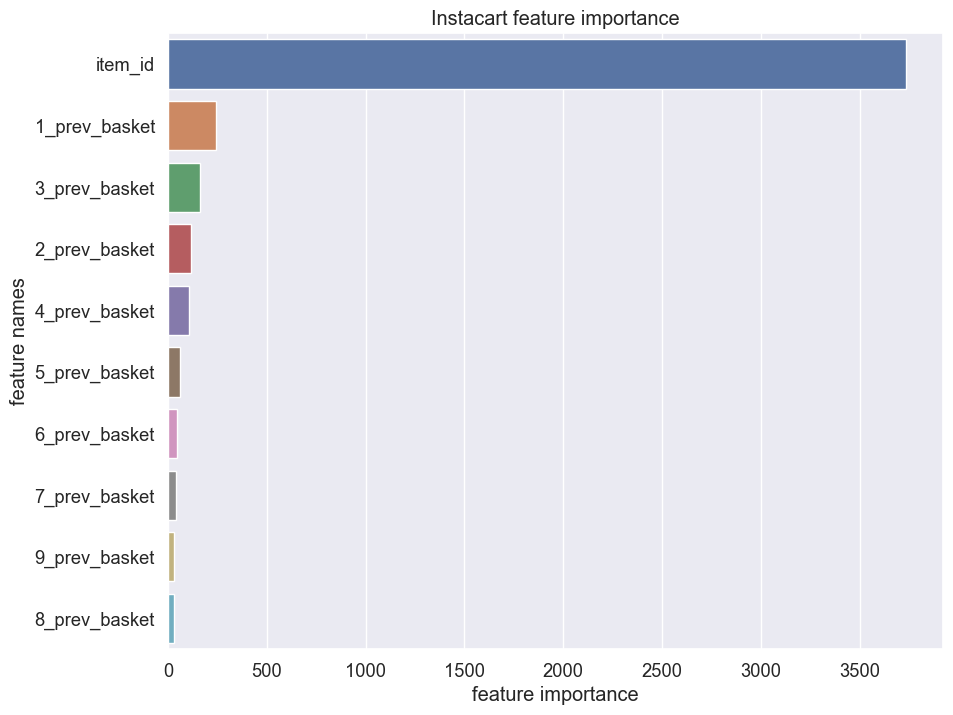

In [73]:
plot_feature_importance(ranker.feature_importances_,X_tr.columns, 'Instacart')

In [74]:
preds = ranker.predict(X_test)
res = test[['user_id', 'item_id']].copy()
res['preds_scores'] = preds
result = predict(res, th = preds.min()-1)
print("ROC AUC =",roc_auc_score(y_test, preds))

ROC AUC = 0.8048758367098379


In [75]:
calculate_metrics(path_test, result)

predictions ready 13246
number of final test users: 13246
5
recall: 0.23872372435246042
ndcg: 0.40648417714179585
precision: 0.3722029291861695
hitrate: 0.7813679601389099
10
recall: 0.31740453207343905
ndcg: 0.3281024505891729
precision: 0.27667975237807646
hitrate: 0.8229654235240828
20
recall: 0.3821246692336774
ndcg: 0.24367172988306593
precision: 0.1826513664502491
hitrate: 0.8408576173939303
B
recall: 0.3014219369579435
ndcg: 0.34880073863892125
precision: 0.3014219369579435
hitrate: 0.7868790578287785


# TaFeng

In [77]:
dataset_name = 'tafeng'

In [78]:
path_train = f'data/{dataset_name}/baskets/train_baskets.csv'
path_test = f'data/{dataset_name}/baskets/test_baskets.csv'
path_val = f'data/{dataset_name}/baskets/valid_baskets.csv'

In [79]:
dataset = Dataset(path_train,path_val, path_test, dataset=dataset_name, history_len=50, basket_len=50)

Total users: 10205
Total items: 13521


In [80]:
train = dataset.create_train_data()

val = dataset.create_val_test_data(mode='val')

test = dataset.create_val_test_data(mode='test')

boosting/data/tafeng/50_train.npz
Done!
boosting/data/tafeng/50_val.npz
Done!
boosting/data/tafeng/50_test.npz
Done!


In [81]:
train.shape, val.shape, test.shape

((2174103, 55), (195824, 55), (193585, 55))

## LGBM Ranker

In [82]:
train = train.drop(train[(train.basket_id==40761)&(train.iloc[:, 48]==0)&(train.labels==0)].index)

In [83]:
train = train.sort_values(by = 'basket_id')
val = val.sort_values(by = 'basket_id')
test = test.sort_values(by = 'basket_id')

In [84]:
# функция для группировки при ранжировании
get_group_size = lambda df: df.reset_index().groupby("basket_id")['basket_id'].count()

In [85]:
# item_id - категориальная фича
train['item_id'] = train['item_id'].sparse.to_dense().astype('category')
val['item_id'] = val['item_id'].sparse.to_dense().astype('category')
test['item_id'] = test['item_id'].sparse.to_dense().astype('category')
# basket_id в int для правильной группировки
train['basket_id'] = train['basket_id'].sparse.to_dense().astype('int')
val['basket_id'] = val['basket_id'].sparse.to_dense().astype('int')
test['basket_id'] = test['basket_id'].sparse.to_dense().astype('int')

In [86]:
train_groups = get_group_size(train)
val_groups = get_group_size(val)

In [87]:
X_tr, y_tr = train.drop(['user_id','labels', 'basket_id'], axis=1), train.labels, 
X_val, y_val = val.drop(['user_id','labels', 'basket_id'], axis=1), val.labels
X_test, y_test = test.drop(['user_id','labels', 'basket_id'], axis=1), test.labels

In [88]:
ranker = LGBMRanker(n_estimators=300, num_leaves=20)

In [89]:
ranker.fit(X_tr, y_tr, group=train_groups, 
           eval_set = [(X_val, y_val)], eval_group=[val_groups], 
           early_stopping_rounds=100, eval_at=(5, 10, 20)
          )

[1]	valid_0's ndcg@5: 0.601334	valid_0's ndcg@10: 0.639051	valid_0's ndcg@20: 0.67124
[2]	valid_0's ndcg@5: 0.604626	valid_0's ndcg@10: 0.642302	valid_0's ndcg@20: 0.674673
[3]	valid_0's ndcg@5: 0.612779	valid_0's ndcg@10: 0.649952	valid_0's ndcg@20: 0.682406
[4]	valid_0's ndcg@5: 0.611194	valid_0's ndcg@10: 0.648209	valid_0's ndcg@20: 0.681395
[5]	valid_0's ndcg@5: 0.614481	valid_0's ndcg@10: 0.651504	valid_0's ndcg@20: 0.684358
[6]	valid_0's ndcg@5: 0.620274	valid_0's ndcg@10: 0.656366	valid_0's ndcg@20: 0.68846
[7]	valid_0's ndcg@5: 0.622566	valid_0's ndcg@10: 0.658244	valid_0's ndcg@20: 0.690895
[8]	valid_0's ndcg@5: 0.625205	valid_0's ndcg@10: 0.660347	valid_0's ndcg@20: 0.692566
[9]	valid_0's ndcg@5: 0.625253	valid_0's ndcg@10: 0.661491	valid_0's ndcg@20: 0.693344
[10]	valid_0's ndcg@5: 0.625746	valid_0's ndcg@10: 0.661108	valid_0's ndcg@20: 0.693144
[11]	valid_0's ndcg@5: 0.625188	valid_0's ndcg@10: 0.660857	valid_0's ndcg@20: 0.693093
[12]	valid_0's ndcg@5: 0.625551	valid_0's n

[98]	valid_0's ndcg@5: 0.631942	valid_0's ndcg@10: 0.669044	valid_0's ndcg@20: 0.702219
[99]	valid_0's ndcg@5: 0.631794	valid_0's ndcg@10: 0.668922	valid_0's ndcg@20: 0.70222
[100]	valid_0's ndcg@5: 0.631703	valid_0's ndcg@10: 0.668937	valid_0's ndcg@20: 0.702277
[101]	valid_0's ndcg@5: 0.63151	valid_0's ndcg@10: 0.669023	valid_0's ndcg@20: 0.70231
[102]	valid_0's ndcg@5: 0.631395	valid_0's ndcg@10: 0.669235	valid_0's ndcg@20: 0.702398
[103]	valid_0's ndcg@5: 0.631743	valid_0's ndcg@10: 0.668949	valid_0's ndcg@20: 0.702225
[104]	valid_0's ndcg@5: 0.631583	valid_0's ndcg@10: 0.668997	valid_0's ndcg@20: 0.702258
[105]	valid_0's ndcg@5: 0.631173	valid_0's ndcg@10: 0.668672	valid_0's ndcg@20: 0.702003
[106]	valid_0's ndcg@5: 0.631029	valid_0's ndcg@10: 0.668653	valid_0's ndcg@20: 0.701884
[107]	valid_0's ndcg@5: 0.630874	valid_0's ndcg@10: 0.668828	valid_0's ndcg@20: 0.701905
[108]	valid_0's ndcg@5: 0.630959	valid_0's ndcg@10: 0.668835	valid_0's ndcg@20: 0.701996
[109]	valid_0's ndcg@5: 0.

[195]	valid_0's ndcg@5: 0.631271	valid_0's ndcg@10: 0.669058	valid_0's ndcg@20: 0.702119
[196]	valid_0's ndcg@5: 0.631175	valid_0's ndcg@10: 0.669142	valid_0's ndcg@20: 0.702092
[197]	valid_0's ndcg@5: 0.631185	valid_0's ndcg@10: 0.66904	valid_0's ndcg@20: 0.701825


LGBMRanker(n_estimators=300, num_leaves=20)

Важность признаков

In [90]:
dict(sorted(dict(zip(X_tr.columns, ranker.feature_importances_)).items(), key=lambda x:x[1],  reverse=True))

{'item_id': 1578,
 49: 81,
 'basket_date': 79,
 48: 55,
 47: 24,
 45: 10,
 44: 6,
 46: 5,
 37: 2,
 41: 2,
 39: 1,
 0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 38: 0,
 40: 0,
 42: 0,
 43: 0}

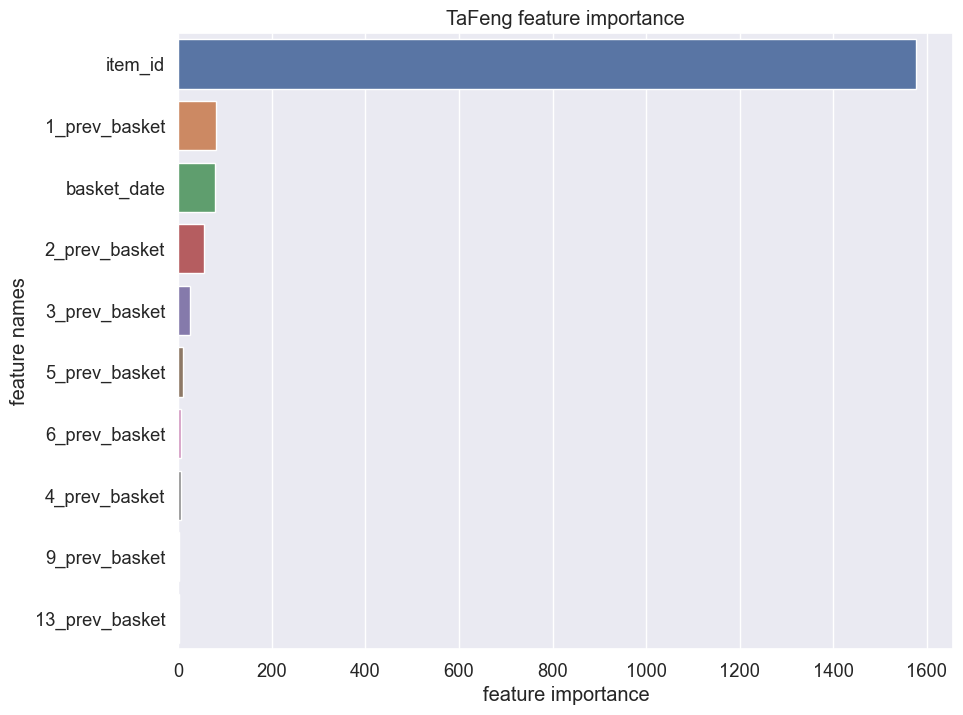

In [91]:
plot_feature_importance(ranker.feature_importances_,X_tr.columns, 'TaFeng')

In [93]:
preds = ranker.predict(X_test)
res = test[['user_id', 'item_id']].copy()
res['preds_scores'] = preds
result = predict(res, th = preds.min()-1)
print("ROC AUC =",roc_auc_score(y_test, preds))

ROC AUC = 0.736792944011331


In [94]:
calculate_metrics(path_test, result)

predictions ready 5007
number of final test users: 5007
5
recall: 0.10431796134819282
ndcg: 0.10962894878801899
precision: 0.09446774515678051
hitrate: 0.3547034152186938
10
recall: 0.13689128000900183
ndcg: 0.08531379248433214
precision: 0.06722588376273218
hitrate: 0.43499101258238465
20
recall: 0.1699515828477447
ndcg: 0.06326571800392917
precision: 0.04501697623327342
hitrate: 0.5022967845016976
B
recall: 0.09739314794164583
ndcg: 0.11107334765006462
precision: 0.09739314794164583
hitrate: 0.37487517475534254
